In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Set up environment and prepare dataset

In [16]:
# import packages and libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [17]:
# import dataset
covid_protein = pd.read_excel('/content/drive/MyDrive/Monash_data_science/24s2/BMS5021/topic_3/SARS-CoV-2 proteins.xlsx')
timecourse = pd.read_excel('/content/drive/MyDrive/Monash_data_science/24s2/BMS5021/topic_3/Timecourse of proteome measurements.xlsx', sheet_name='Table')

## Data overview and pre-processing

In [18]:
covid_protein.head()

,Accession,Entry name,Protein name,Gene names,Length (amino acids)
0,P0DTC1,R1A_SARS2,Replicase polyprotein 1a[...],NaN,4405
1,P0DTD1,R1AB_SARS2,Replicase polyprotein 1ab[...],"rep, 1a-1b",7096
2,P0DTC2,SPIKE_SARS2,Spike glycoprotein[...],"S, 2",1273
3,P0DTC7,NS7A_SARS2,ORF7a protein[...],7a,121
4,P0DTC4,VEMP_SARS2,Envelope small membrane protein[...],"E, 4",75


In [19]:
timecourse.head()

,UniProt Accession,Gene Symbol,Control 2h_1,Control 2h_2,Control 2h_3,Control 6h_1,Control 6h_2,Control 6h_3,Control 10h_1,Control 10h_2,...,Virus 24h_2,Virus 24h_3,Ratio 2h,Ratio 6h,Ratio 10h,Ratio 24h,P value 2h,P value 6h,P value 10h,P value 24h
0,A0A0B4J1V1,IGHV3-21,409.991,406.229,412.542,408.409,401.301,429.944,424.944,402.828,...,368.183,505.414,0.050572,0.035375,0.029738,-0.004442,0.020874,0.444649,0.617162,0.976142
1,A0A0B4J2D5,NaN,1546.010,1498.820,1626.610,1537.520,1555.540,1526.200,1559.430,1435.430,...,1626.610,1649.350,-0.042739,-0.031764,0.025155,0.122305,0.421604,0.607339,0.586683,0.006431
2,A0A0B4J2F0,PIGBOS1,110.127,116.383,113.648,104.409,117.992,108.311,105.915,120.005,...,118.637,110.210,0.016459,0.022551,-0.038960,0.073575,0.567712,0.792752,0.669514,0.287247
3,A0AV96,RBM47,1176.220,1198.700,1142.530,1283.180,1282.270,1217.570,1062.100,1131.360,...,951.055,987.080,0.017315,-0.028862,0.039890,-0.098496,0.747481,0.512741,0.353469,0.030092
4,A0AVT1,UBA6,2658.050,2570.760,2554.980,2561.470,2526.840,2552.540,2487.210,2476.170,...,2610.680,2552.660,0.001688,0.005785,0.043469,0.084703,0.933593,0.469432,0.154833,0.014052


In [20]:
timecourse.columns

Index(['UniProt Accession', 'Gene Symbol', 'Control 2h_1', 'Control 2h_2',
       'Control 2h_3', 'Control 6h_1', 'Control 6h_2', 'Control 6h_3',
       'Control 10h_1', 'Control 10h_2', 'Control 10h_3', 'Control 24h_1',
       'Control 24h_2', 'Control 24h_3', 'Virus 2h_1', 'Virus 2h_2',
       'Virus 2h_3', 'Virus 6h_1', 'Virus 6h_2', 'Virus 6h_3', 'Virus 10h_1',
       'Virus 10h_2', 'Virus 10h_3', 'Virus 24h_1', 'Virus 24h_2',
       'Virus 24h_3', 'Ratio 2h', 'Ratio 6h', 'Ratio 10h', 'Ratio 24h',
       'P value 2h', 'P value 6h', 'P value 10h', 'P value 24h'],
      dtype='object')

There are three replicates, 4 time points.

Compare at a given time point, control vesus infected, then look across time as well.

For visulisation purpose, we will first perform log 10 transformation on those values due to their large range.

In the column 'Control_6h_1' there are zero value, so it is important to add a value shift when performing log transformation.

In [21]:
# log 10 transformation
epsilon = 1e-6

# Columns containing expression data where 'Control' or 'Virus' is in the column name
expression_columns = [col for col in timecourse.columns if 'Control' in col or 'Virus' in col]

# Apply log10 transformation after adding a small constant
timecourse[expression_columns] = timecourse[expression_columns].apply(lambda x: np.log10(x + epsilon))

In [22]:
# distinguish viral protein from human
covid = list(covid_protein['Accession'])

covid_timecourse = timecourse[timecourse['UniProt Accession'].isin(covid)].reset_index(drop=True)
human_timecourse = timecourse[~timecourse['UniProt Accession'].isin(covid)].reset_index(drop=True)

print(len(covid_timecourse))
print(len(human_timecourse))



9
6371


## Check the distribution of expression values for each timepoint/sample/replicate

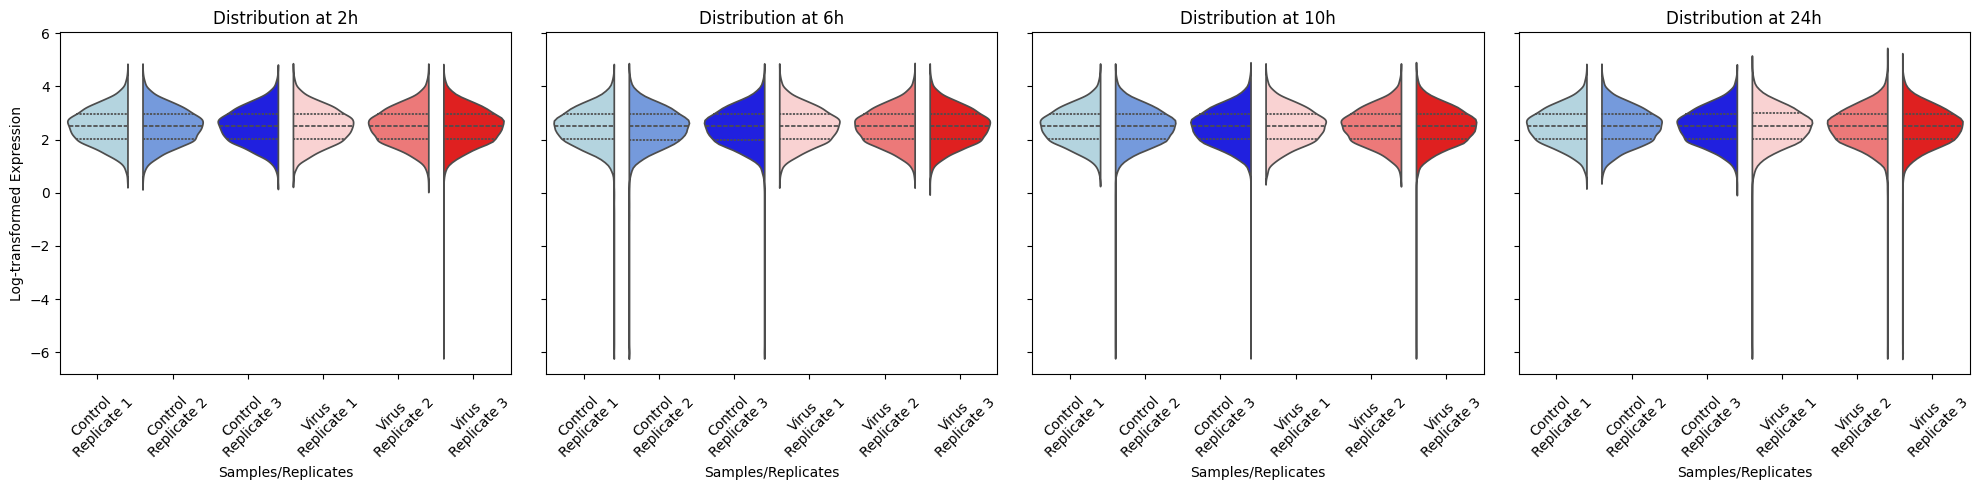

In [23]:
# Define timepoints and samples
timepoints = ['2h', '6h', '10h', '24h']
samples = ['Control', 'Virus']
colors = {
    'Control_1': '#add8e6',  # Light blue
    'Control_2': '#6495ed',  # Medium blue
    'Control_3': '#0000ff',  # Dark blue
    'Virus_1': '#ffcccc',    # Light red
    'Virus_2': '#ff6666',    # Medium red
    'Virus_3': '#ff0000'     # Dark red
}

# Create a figure with subplots
fig, axes = plt.subplots(1, len(timepoints), figsize=(20, 5), sharey=True)

for ax, timepoint in zip(axes, timepoints):
    # Prepare data
    plot_data = pd.DataFrame()
    for sample in samples:
        for replicate in range(1, 4):
            col_name = f'{sample} {timepoint}_{replicate}'
            temp_df = pd.DataFrame()
            temp_df['Expression'] = timecourse[col_name]
            temp_df['Sample'] = f'{sample}_{replicate}'
            plot_data = pd.concat([plot_data, temp_df], ignore_index=True)  # Ensure a unique index

    # Plot violin plot with updated parameters
    sns.violinplot(x='Sample', y='Expression', data=plot_data, palette=colors, ax=ax,
                   hue='Sample', split=True, inner='quartile', legend=False, density_norm='width')
    ax.set_title(f'Distribution at {timepoint}')
    ax.set_xlabel('Samples/Replicates')
    ax.set_ylabel('Log-transformed Expression' if ax == axes[0] else '')

    # Set x-ticks and x-tick labels correctly
    tick_positions = np.arange(len(plot_data['Sample'].unique()))
    ax.set_xticks(tick_positions)  # Set the positions for the ticks
    ax.set_xticklabels([f'{sample}\nReplicate {i}' for sample in samples for i in range(1, 4)], rotation=45)

plt.tight_layout()
plt.show()

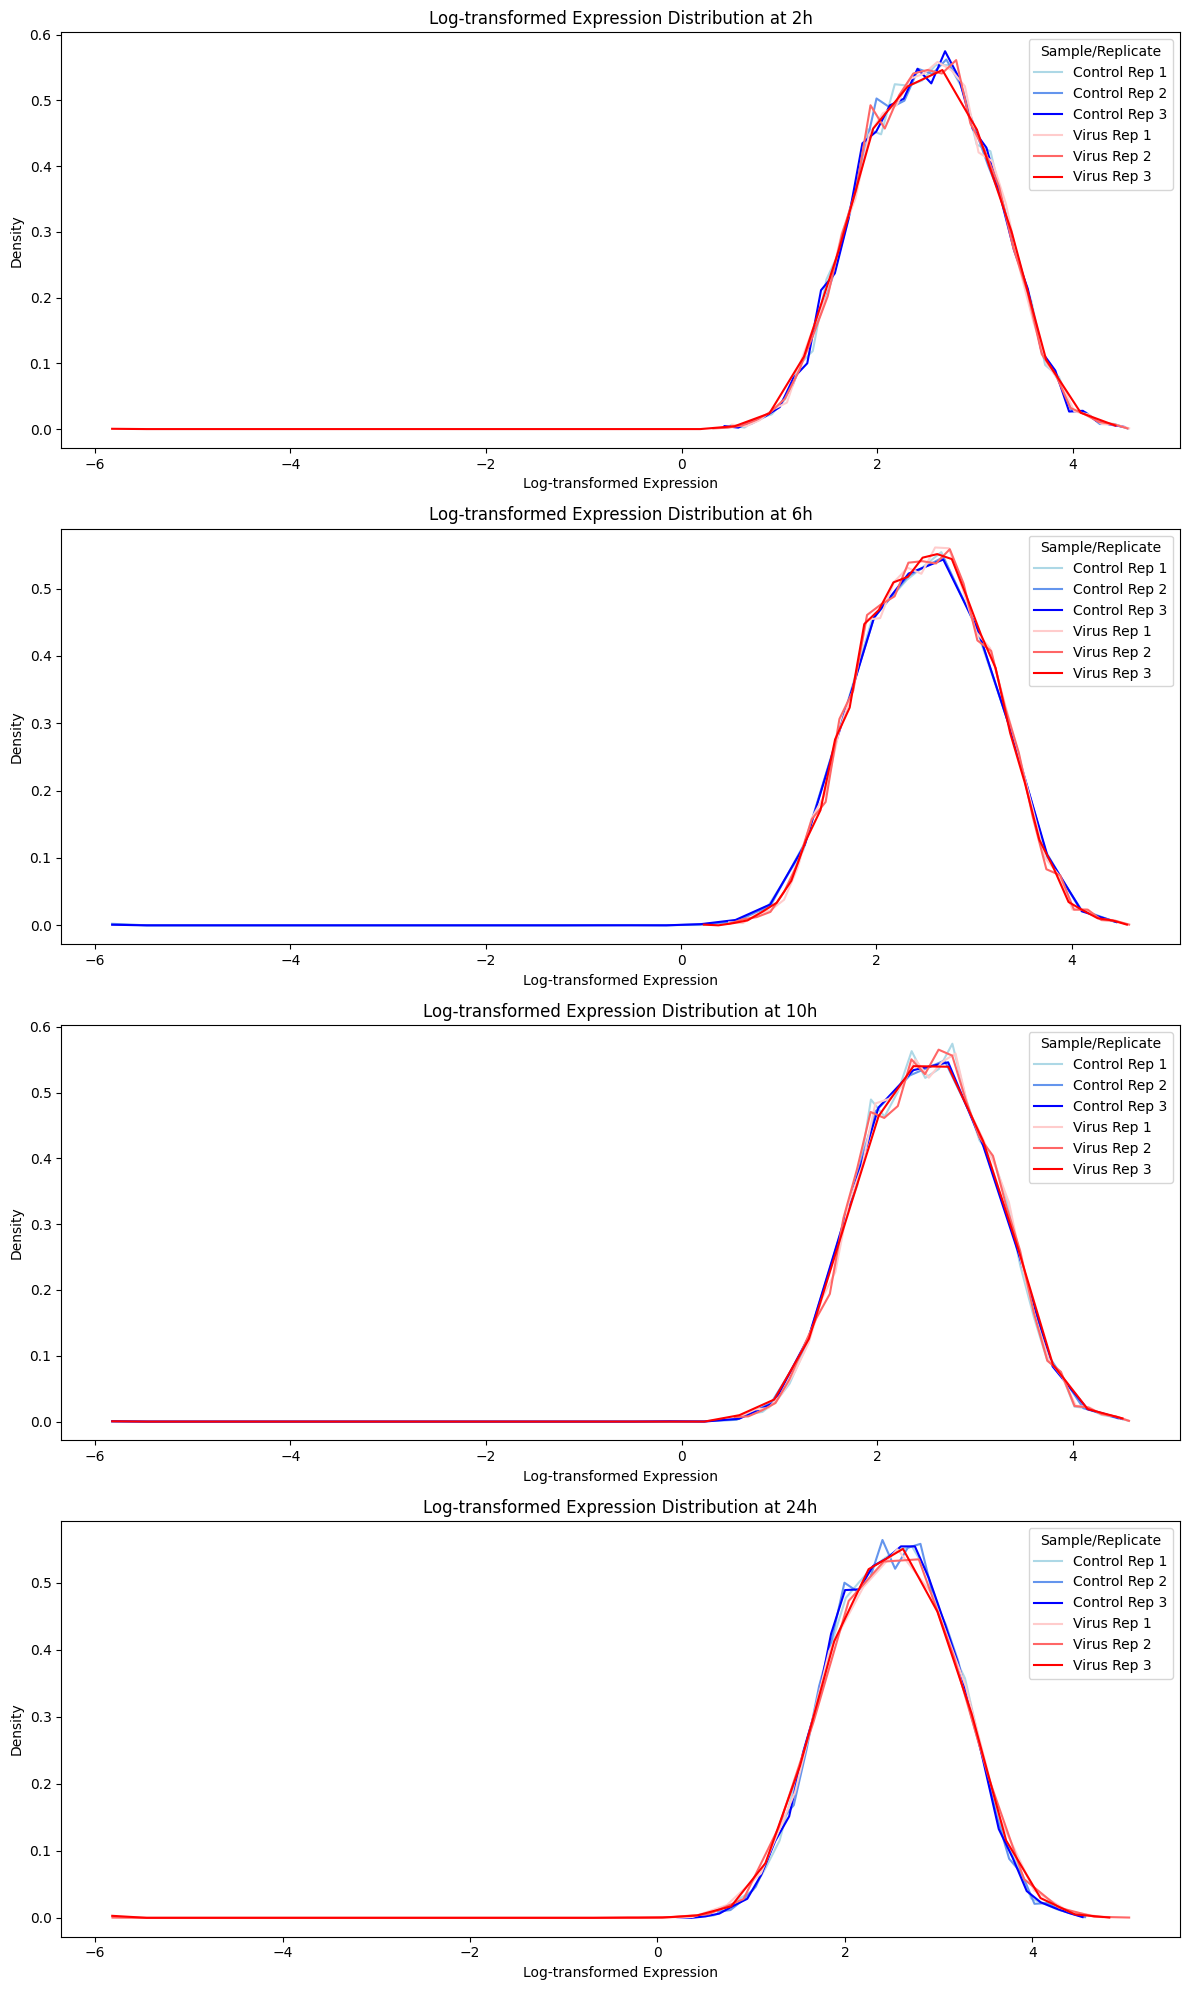

In [24]:
# Define timepoints, samples, and color mapping for replicates
timepoints = ['2h', '6h', '10h', '24h']
samples = ['Control', 'Virus']
replicates = ['1', '2', '3']
colors = {
    'Control_1': '#add8e6',  # Light blue
    'Control_2': '#6495ed',  # Medium blue
    'Control_3': '#0000ff',  # Dark blue
    'Virus_1': '#ffcccc',    # Light red
    'Virus_2': '#ff6666',    # Medium red
    'Virus_3': '#ff0000'     # Dark red
}

# Create a figure with subplots
fig, axes = plt.subplots(nrows=len(timepoints), ncols=1, figsize=(12, 20))

for idx, ax in enumerate(axes):
    timepoint = timepoints[idx]
    # Prepare data for histogram as line plot
    for sample in samples:
        for i, replicate in enumerate(replicates):
            col_name = f'{sample} {timepoint}_{replicate}'
            data = timecourse[col_name].dropna()  # Drop NaN values to ensure no plotting errors
            # Compute the histogram
            counts, bin_edges = np.histogram(data, bins=30, density=True)
            # Calculate the center of bins
            bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
            # Plot using lines
            ax.plot(bin_centers, counts, color=colors[f'{sample}_{replicate}'], label=f'{sample} Rep {replicate}')

    ax.set_title(f'Log-transformed Expression Distribution at {timepoint}')
    ax.set_xlabel('Log-transformed Expression')
    ax.set_ylabel('Density')
    ax.legend(title='Sample/Replicate')

plt.tight_layout()
plt.show()

## Which viral proteins are detected at which timepoints?

For the viral proteins that are detected, what does the expression profile look like for the control vs virus samples?



Use the actual relative intensity values for this. (There shouldn’t of course be any viral protein expression in the control samples, but all proteins are assigned a low, background value if no signal was detected, hence why there are values for all proteins on all rows.) I would recommend a lineplot, with time on the x-axis and expression on the y-axis. For example, something like this, where it is possible to see the variance in expression values across the three replicates for each sample at each timepoint:

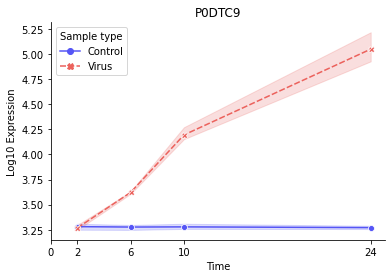

In [25]:
# check the viral proteins
covid_timecourse

,UniProt Accession,Gene Symbol,Control 2h_1,Control 2h_2,Control 2h_3,Control 6h_1,Control 6h_2,Control 6h_3,Control 10h_1,Control 10h_2,...,Virus 24h_2,Virus 24h_3,Ratio 2h,Ratio 6h,Ratio 10h,Ratio 24h,P value 2h,P value 6h,P value 10h,P value 24h
0,P0DTC1,NaN,1.592764,1.542661,1.570508,1.606115,1.553028,1.638571,1.615257,1.581789,...,2.710656,2.776623,0.039088,0.147017,1.033963,3.674875,0.725949,0.164751,0.000152,0.000475
1,P0DTC2,NaN,2.727019,2.790695,2.705959,2.831083,2.789280,2.796079,2.760647,2.779972,...,4.264712,4.154911,0.036043,0.680449,2.518067,4.717300,0.751902,0.002356,0.004366,0.000383
2,P0DTC3,NaN,2.037677,1.931809,1.819865,1.993590,1.981509,1.842430,2.048877,1.986789,...,3.415793,3.122468,0.033042,0.513876,1.568583,4.552676,0.913158,0.253106,0.038866,0.012565
3,P0DTC5,NaN,2.292783,2.459652,2.360190,2.311629,2.501025,2.418396,2.293164,2.525537,...,4.440394,4.080464,0.058020,0.594536,2.490844,5.961361,0.827902,0.249032,0.130415,0.101214
4,P0DTC6,NaN,1.641833,1.692282,1.725681,1.623983,1.636009,1.767236,1.640906,1.726909,...,2.710001,2.743424,-0.077997,0.390072,0.761931,3.496425,0.651613,0.103919,0.008175,0.000050
5,P0DTC7,NaN,1.684049,1.797218,1.861398,1.658049,1.820109,1.913381,1.679945,1.835497,...,3.084036,3.881744,0.141459,1.531263,3.415351,5.635877,0.682377,0.248183,0.138682,0.212725
6,P0DTC8,NaN,1.413041,1.447344,1.397512,1.439179,1.472451,1.454493,1.300609,1.499032,...,3.041385,2.457352,-0.024870,1.175413,3.316865,4.528193,0.900313,0.110012,0.125219,0.112684
7,P0DTC9,NaN,3.249419,3.309206,3.281928,3.283826,3.296617,3.247448,3.266852,3.308942,...,5.218428,5.002930,-0.045199,1.145207,3.055487,5.970873,0.583522,0.000017,0.000673,0.009528
8,P0DTD2,NaN,2.311902,2.313989,2.299714,2.319241,2.329552,2.295827,2.281218,2.299649,...,3.619073,3.550830,0.040581,0.266253,1.501847,4.516557,0.235753,0.012200,0.001845,0.009432


In [26]:
# get the list of viral proteins
viral_proteins = covid_timecourse['UniProt Accession'].unique()
viral_proteins

array(['P0DTC1', 'P0DTC2', 'P0DTC3', 'P0DTC5', 'P0DTC6', 'P0DTC7',
       'P0DTC8', 'P0DTC9', 'P0DTD2'], dtype=object)

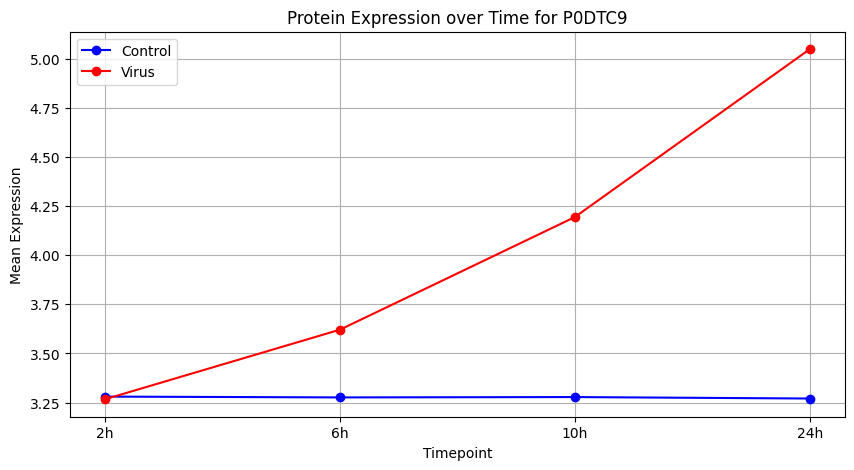

In [27]:
# graph with just value for each viral protein
# ['P0DTC1', 'P0DTC2', 'P0DTC3', 'P0DTC5', 'P0DTC6', 'P0DTC7', 'P0DTC8', 'P0DTC9', 'P0DTD2']

# Sample data extraction for one protein
protein_id = 'P0DTC9'
data = covid_timecourse[covid_timecourse['UniProt Accession'] == protein_id]

# Define timepoints and samples
timepoints = ['2h', '6h', '10h', '24h']
samples = ['Control', 'Virus']

# Preparing the plot data
plot_data = {'Control': [], 'Virus': []}

for timepoint in timepoints:
    for sample in samples:
        cols = [col for col in data.columns if col.startswith(f'{sample} {timepoint}')]
        mean_value = data[cols].mean(axis=1).values  # Mean across replicates
        if mean_value.size > 0:  # Check if there is data
            plot_data[sample].append(mean_value[0])
        else:
            plot_data[sample].append(np.nan)  # Append NaN if no data is available

# Convert lists to numpy arrays for plotting
control_data = np.array(plot_data['Control'])
virus_data = np.array(plot_data['Virus'])

# Create a plot
plt.figure(figsize=(10, 5))
plt.plot(timepoints, control_data, marker='o', color='blue', label='Control')
plt.plot(timepoints, virus_data, marker='o', color='red', label='Virus')

# Adding title and labels
plt.title(f'Protein Expression over Time for {protein_id}')
plt.xlabel('Timepoint')
plt.ylabel('Mean Expression')
plt.legend()
plt.grid(True)
plt.show()

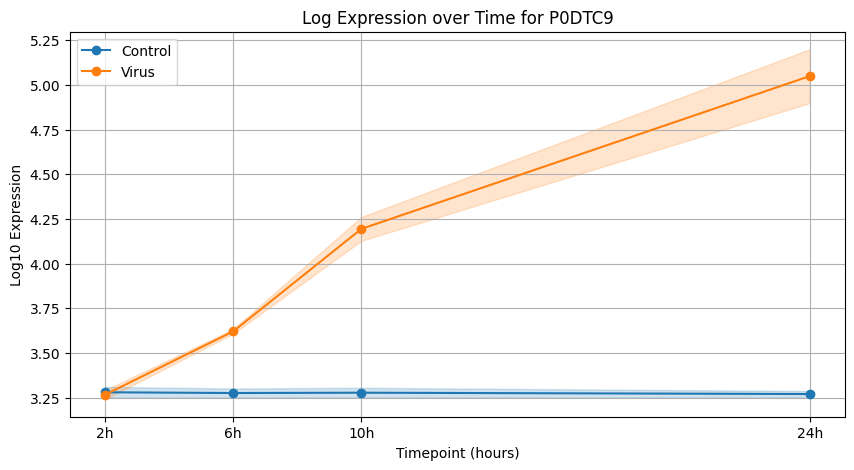

In [28]:
# graph with value and shaded confidence interval
# ['P0DTC1', 'P0DTC2', 'P0DTC3', 'P0DTC5', 'P0DTC6', 'P0DTC7', 'P0DTC8', 'P0DTC9', 'P0DTD2']

# Sample data extraction for one protein
protein_id = 'P0DTC9'
data = covid_timecourse[covid_timecourse['UniProt Accession'] == protein_id]

# Define timepoints, samples, and numeric representation for proportional x-axis
timepoints = ['2h', '6h', '10h', '24h']
timepoint_hours = [2, 6, 10, 24]  # Hours for x-axis
samples = ['Control', 'Virus']

# Preparing the plot data
plot_data = {'Control': [], 'Virus': []}
plot_std = {'Control': [], 'Virus': []}  # Store standard deviations

for timepoint in timepoints:
    for sample in samples:
        cols = [col for col in data.columns if col.startswith(f'{sample} {timepoint}')]
        mean_value = data[cols].mean(axis=1).values  # Mean across replicates
        std_value = data[cols].std(axis=1).values  # Standard deviation across replicates
        plot_data[sample].append(mean_value[0] if mean_value.size > 0 else np.nan)
        plot_std[sample].append(std_value[0] if std_value.size > 0 else np.nan)

# Convert lists to numpy arrays for plotting
control_data = np.array(plot_data['Control'])
virus_data = np.array(plot_data['Virus'])
control_std = np.array(plot_std['Control'])
virus_std = np.array(plot_std['Virus'])

# Create a plot with shaded error area
plt.figure(figsize=(10, 5))
for sample, color in zip(['Control', 'Virus'], ['#1f77b4', '#ff7f0e']):  # Blue for control, orange for virus
    mean_data = np.array(plot_data[sample])
    std_data = np.array(plot_std[sample])
    plt.plot(timepoint_hours, mean_data, marker='o', linestyle='-', color=color, label=sample)
    plt.fill_between(timepoint_hours, mean_data - std_data, mean_data + std_data, color=color, alpha=0.2)

# Adding title and labels
plt.title(f'Log Expression over Time for {protein_id}')
plt.xlabel('Timepoint (hours)')
plt.ylabel('Log10 Expression')
plt.xticks(timepoint_hours, labels=timepoints)
plt.legend()
plt.grid(True)
plt.show()


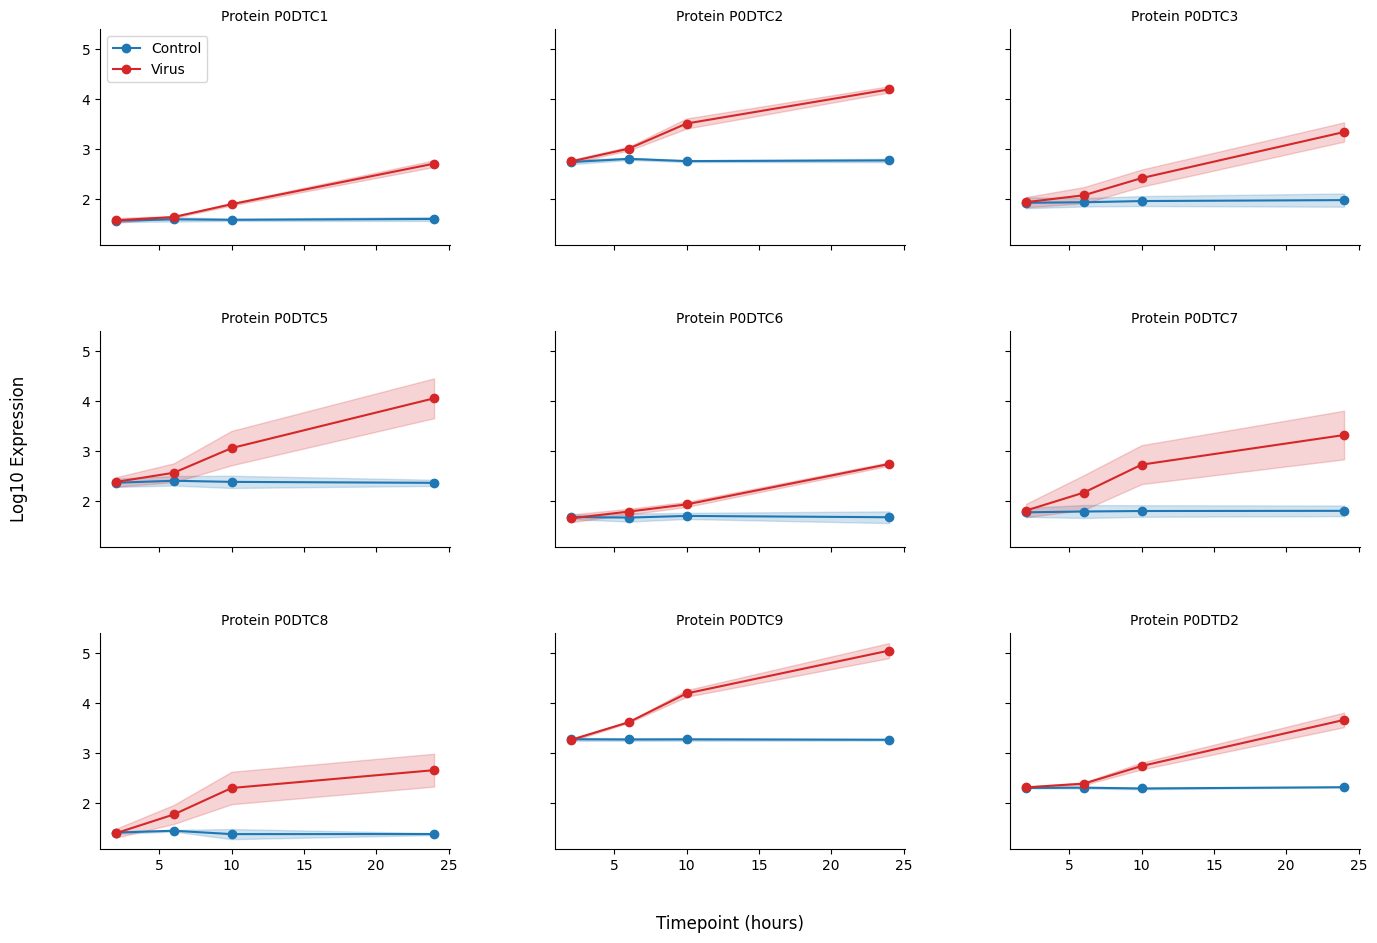

In [29]:
# List of specified proteins to plot
proteins = ['P0DTC1', 'P0DTC2', 'P0DTC3', 'P0DTC5', 'P0DTC6', 'P0DTC7', 'P0DTC8', 'P0DTC9', 'P0DTD2']

# Define timepoints and numeric representation for the x-axis
timepoints = ['2h', '6h', '10h', '24h']
timepoint_hours = [2, 6, 10, 24]
samples = ['Control', 'Virus']

# Set up a 3x3 grid layout for 9 protein subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 10), sharex=True, sharey=True)

# Loop through each protein to plot
for i, protein_id in enumerate(proteins):
    data = covid_timecourse[covid_timecourse['UniProt Accession'] == protein_id]

    # Initialize data and standard deviation storage
    plot_data = {'Control': [], 'Virus': []}
    plot_std = {'Control': [], 'Virus': []}

    for timepoint in timepoints:
        for sample in samples:
            cols = [col for col in data.columns if col.startswith(f'{sample} {timepoint}')]
            mean_value = data[cols].mean(axis=1).values  # Mean across replicates
            std_value = data[cols].std(axis=1).values  # Standard deviation
            plot_data[sample].append(mean_value[0] if mean_value.size > 0 else np.nan)
            plot_std[sample].append(std_value[0] if std_value.size > 0 else np.nan)

    # Convert lists to numpy arrays for plotting
    control_data = np.array(plot_data['Control'])
    virus_data = np.array(plot_data['Virus'])
    control_std = np.array(plot_std['Control'])
    virus_std = np.array(plot_std['Virus'])

    # Select the appropriate subplot
    ax = axes[i // 3, i % 3]

    # Colors for control (blue) and virus (red) data
    color_virus = '#d62728'
    color_control = '#1f77b4'

    # Plot Control (blue) and Virus (red) with shaded confidence intervals
    for j, (sample, color) in enumerate([('Control', color_control), ('Virus', color_virus)]):
        mean_data = np.array(plot_data[sample])
        std_data = np.array(plot_std[sample])
        label = sample if i == 0 else None  # Only label in the first plot
        ax.plot(timepoint_hours, mean_data, marker='o', linestyle='-', color=color, label=label)
        ax.fill_between(timepoint_hours, mean_data - std_data, mean_data + std_data, color=color, alpha=0.2)

    # Setting title and hiding top and right spines
    ax.set_title(f'Protein {protein_id}', fontsize=10)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Adjust layout and padding for x and y labels
plt.subplots_adjust(left=0.08, right=0.92, bottom=0.1, top=0.92, wspace=0.3, hspace=0.4)

# Add shared x-axis and y-axis labels with padding
fig.text(0.5, 0.02, 'Timepoint (hours)', ha='center', fontsize=12)
fig.text(0.02, 0.5, 'Log10 Expression', va='center', rotation='vertical', fontsize=12)

# Show legend only once
axes[0, 0].legend(loc='upper left')

plt.show()


## Do the same for the viral proteins, but use the “Ratio” values that are in the table of results

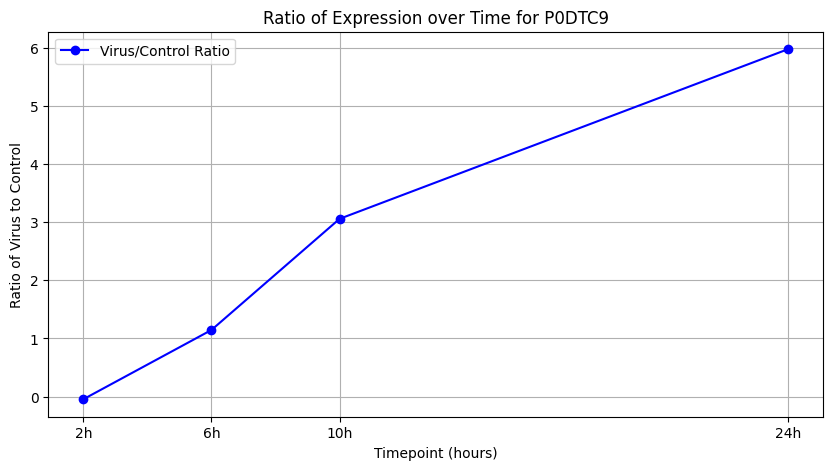

In [30]:
# Sample data extraction for one protein
protein_id = 'P0DTC9'
data = covid_timecourse[covid_timecourse['UniProt Accession'] == protein_id]

# Define timepoints and numeric representation for proportional x-axis
timepoints = ['2h', '6h', '10h', '24h']
timepoint_hours = [2, 6, 10, 24]  # Hours for x-axis

# Prepare the plot data for ratios
ratios = []

for timepoint in timepoints:
    col_name = f'Ratio {timepoint}'
    value = data[col_name].values  # Get the value for the ratio at each timepoint
    ratios.append(value[0] if len(value) > 0 else np.nan)  # Append the ratio or NaN if missing

# Convert list to numpy array for plotting
ratios = np.array(ratios)

# Create a plot
plt.figure(figsize=(10, 5))
plt.plot(timepoint_hours, ratios, marker='o', linestyle='-', color='blue', label='Virus/Control Ratio')

# Adding title and labels
plt.title(f'Ratio of Expression over Time for {protein_id}')
plt.xlabel('Timepoint (hours)')
plt.ylabel('Ratio of Virus to Control')
plt.xticks(timepoint_hours, labels=timepoints)
plt.legend()
plt.grid(True)
plt.show()

## Compare average ratio across viral and human protein

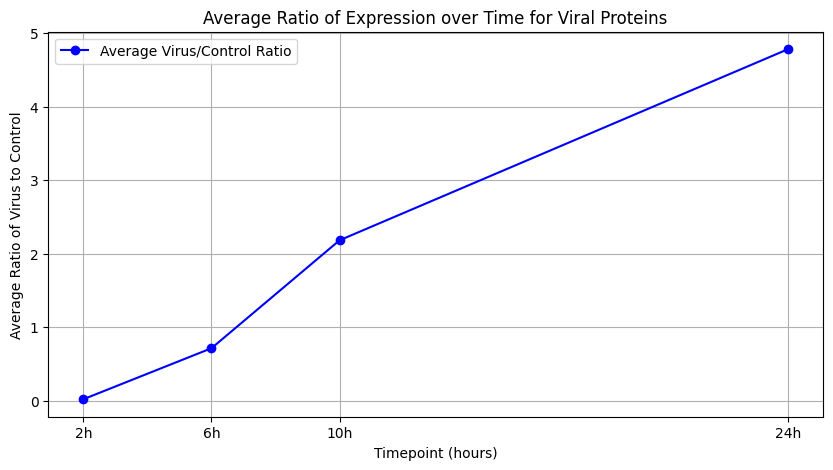

In [31]:
# Define timepoints and numeric representation for proportional x-axis
timepoints = ['2h', '6h', '10h', '24h']
timepoint_hours = [2, 6, 10, 24]  # Hours for x-axis

# Prepare the plot data for average ratios
average_ratios = []

for timepoint in timepoints:
    col_name = f'Ratio {timepoint}'
    # Calculate the mean ratio for all viral proteins at each timepoint
    mean_ratio = covid_timecourse[col_name].mean()
    average_ratios.append(mean_ratio)

# Convert list to numpy array for plotting
average_ratios = np.array(average_ratios)

# Create a plot
plt.figure(figsize=(10, 5))
plt.plot(timepoint_hours, average_ratios, marker='o', linestyle='-', color='blue', label='Average Virus/Control Ratio')

# Adding title and labels
plt.title('Average Ratio of Expression over Time for Viral Proteins')
plt.xlabel('Timepoint (hours)')
plt.ylabel('Average Ratio of Virus to Control')
plt.xticks(timepoint_hours, labels=timepoints)
plt.legend()
plt.grid(True)
plt.show()

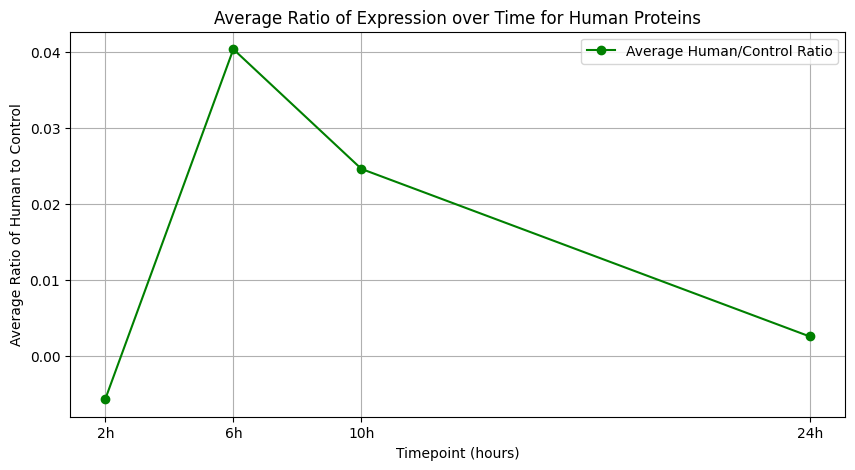

In [32]:
# Define timepoints and numeric representation for proportional x-axis
timepoints = ['2h', '6h', '10h', '24h']
timepoint_hours = [2, 6, 10, 24]  # Hours for x-axis

# Prepare the plot data for average ratios
average_ratios = []

for timepoint in timepoints:
    col_name = f'Ratio {timepoint}'
    # Calculate the mean ratio for all human proteins at each timepoint
    mean_ratio = human_timecourse[col_name].mean()
    average_ratios.append(mean_ratio)

# Convert list to numpy array for plotting
average_ratios = np.array(average_ratios)

# Create a plot
plt.figure(figsize=(10, 5))
plt.plot(timepoint_hours, average_ratios, marker='o', linestyle='-', color='green', label='Average Human/Control Ratio')

# Adding title and labels
plt.title('Average Ratio of Expression over Time for Human Proteins')
plt.xlabel('Timepoint (hours)')
plt.ylabel('Average Ratio of Human to Control')
plt.xticks(timepoint_hours, labels=timepoints)
plt.legend()
plt.grid(True)
plt.show()

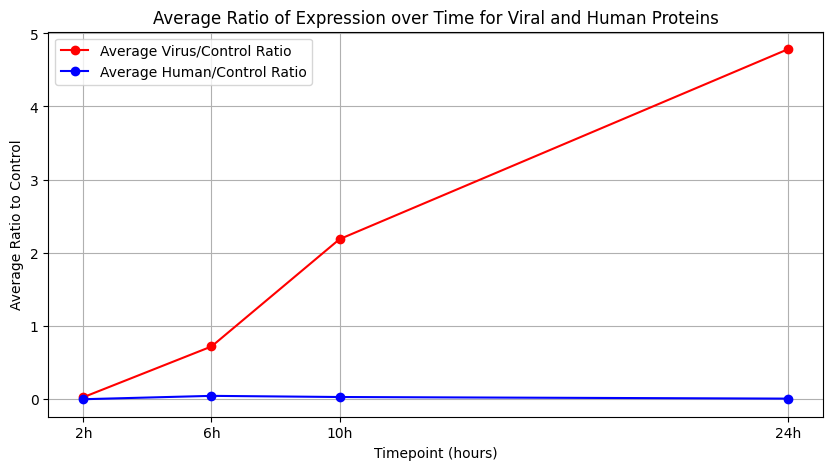

In [33]:

# Define timepoints and numeric representation for proportional x-axis
timepoints = ['2h', '6h', '10h', '24h']
timepoint_hours = [2, 6, 10, 24]  # Hours for x-axis

# Prepare the plot data for average ratios for viral proteins
average_ratios_viral = []
for timepoint in timepoints:
    col_name = f'Ratio {timepoint}'
    mean_ratio = covid_timecourse[col_name].mean()
    average_ratios_viral.append(mean_ratio)
average_ratios_viral = np.array(average_ratios_viral)

# Prepare the plot data for average ratios for human proteins
average_ratios_human = []
for timepoint in timepoints:
    col_name = f'Ratio {timepoint}'
    mean_ratio = human_timecourse[col_name].mean()
    average_ratios_human.append(mean_ratio)
average_ratios_human = np.array(average_ratios_human)

# Create a single plot for both viral and human ratios
plt.figure(figsize=(10, 5))

# Plot viral protein ratios
plt.plot(timepoint_hours, average_ratios_viral, marker='o', linestyle='-', color='red', label='Average Virus/Control Ratio')

# Plot human protein ratios
plt.plot(timepoint_hours, average_ratios_human, marker='o', linestyle='-', color='blue', label='Average Human/Control Ratio')

# Adding title and labels
plt.title('Average Ratio of Expression over Time for Viral and Human Proteins')
plt.xlabel('Timepoint (hours)')
plt.ylabel('Average Ratio to Control')
plt.xticks(timepoint_hours, labels=timepoints)
plt.legend()
plt.grid(True)
plt.show()


## How you can show the overall change in expression for the proteome

A common method used in proteomics is a volcano plot. You may have come across or plotted these previously. A volcano plot has the fold change (i.e. ratio, and usually as log2 values, which are already in your table) along the x-axis and the negative log10 P value on the y-axis. The latter is used so that things that are more significant have a larger value. Given you already have log2 ratio values in the table, the only new thing you need is to -log10 transform the P values and then you can plot as a scatter plot.

In [34]:
# perform -log10 transform for the p values at each time point

# Define the timepoints
timepoints = ['2h', '6h', '10h', '24h']

# Create a new DataFrame to hold the modified data
transformed_data = covid_timecourse[['UniProt Accession', 'Gene Symbol']].copy()

# Perform -log10 transformation on P values and copy over ratio values
for tp in timepoints:
    p_value_col = f'P value {tp}'
    ratio_col = f'Ratio {tp}'
    log_p_value_col = f'-log10 P value {tp}'

    # -log10 transformation of the P values
    transformed_data[log_p_value_col] = -np.log10(covid_timecourse[p_value_col])

    # Copy over the ratio values
    transformed_data[ratio_col] = covid_timecourse[ratio_col]

# Now, 'transformed_data' contains the transformed p-values and the ratio values
# Display the transformed data
print(transformed_data.head())

# Optional: Save this to a new CSV for further use
transformed_data.to_csv('transformed_timecourse_data.csv', index=False)

  UniProt Accession Gene Symbol  -log10 P value 2h  Ratio 2h  \
0            P0DTC1         NaN           0.139094  0.039088   
1            P0DTC2         NaN           0.123839  0.036043   
2            P0DTC3         NaN           0.039454  0.033042   
3            P0DTC5         NaN           0.082021  0.058020   
4            P0DTC6         NaN           0.186011 -0.077997   

   -log10 P value 6h  Ratio 6h  -log10 P value 10h  Ratio 10h  \
0           0.783173  0.147017            3.818920   1.033963   
1           2.627867  0.680449            2.359921   2.518067   
2           0.596698  0.513876            1.410431   1.568583   
3           0.603744  0.594536            0.884672   2.490844   
4           0.983306  0.390072            2.087512   0.761931   

   -log10 P value 24h  Ratio 24h  
0            3.323505   3.674875  
1            3.416690   4.717300  
2            1.900852   4.552676  
3            0.994758   5.961361  
4            4.302507   3.496425  


## Create a volcano plot for each of the timepoints

Note that things are considered significantly up-regulated if the log2 value is ≥1 (i.e. 2-fold change) and has a -log10 P value of ≥1.3 (i.e. P value of <0.05), and significantly down-regulated if the log2 value is ≤1 and has a -log10 P value of ≥1.3.


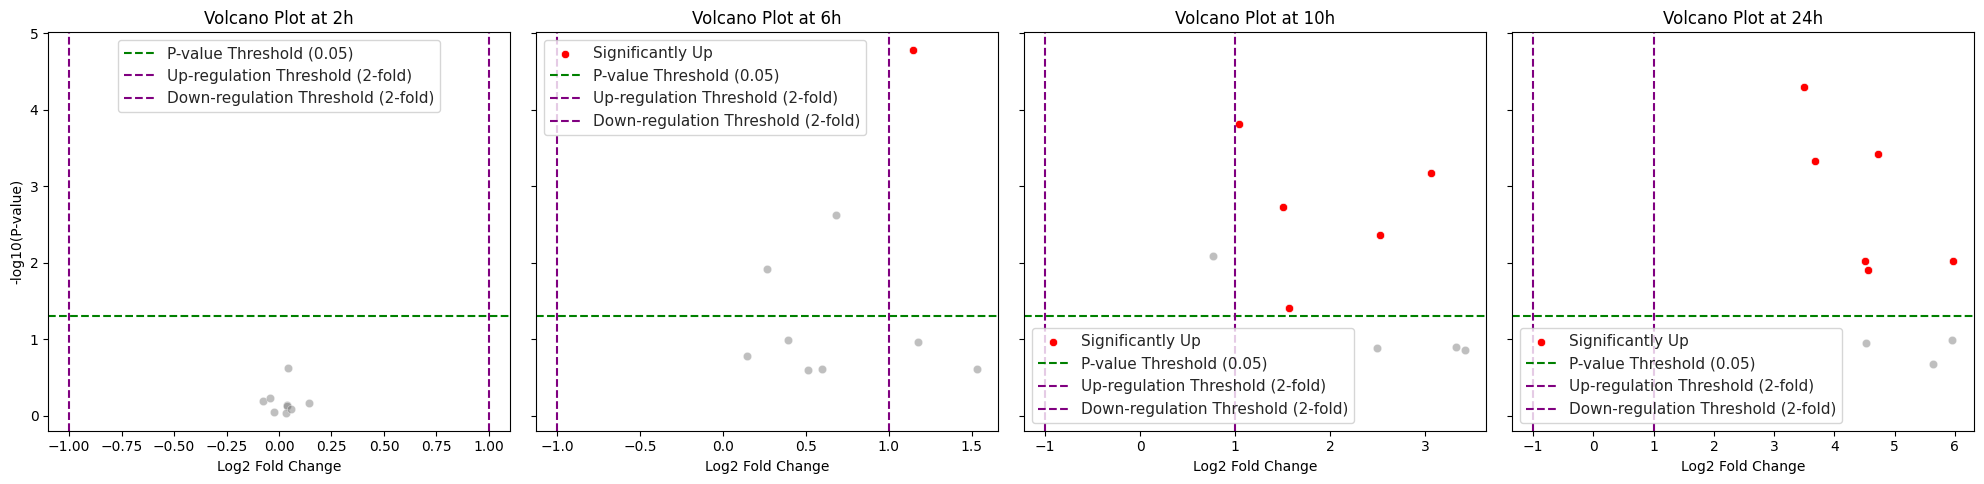

In [35]:
# use the transformed_data to produce volcano plot

# Define timepoints
timepoints = ['2h', '6h', '10h', '24h']

# Create a figure with subplots
fig, axes = plt.subplots(1, len(timepoints), figsize=(20, 5), sharey=True)

# Set global aesthetics for seaborn
sns.set(style="whitegrid")

for i, tp in enumerate(timepoints):
    ax = axes[i]
    ratio_col = f'Ratio {tp}'
    log_p_value_col = f'-log10 P value {tp}'

    # Plotting all data points
    sns.scatterplot(x=ratio_col, y=log_p_value_col, data=transformed_data, ax=ax, color='gray', alpha=0.5)

    # Highlighting significantly up-regulated proteins
    significantly_up = transformed_data[(transformed_data[ratio_col] >= 1) & (transformed_data[log_p_value_col] >= 1.3)]
    sns.scatterplot(x=ratio_col, y=log_p_value_col, data=significantly_up, ax=ax, color='red', label='Significantly Up')

    # Highlighting significantly down-regulated proteins
    significantly_down = transformed_data[(transformed_data[ratio_col] <= -1) & (transformed_data[log_p_value_col] >= 1.3)]
    sns.scatterplot(x=ratio_col, y=log_p_value_col, data=significantly_down, ax=ax, color='blue', label='Significantly Down')

    # Adding reference lines for significance thresholds
    ax.axhline(y=1.3, color='green', linestyle='--', label='P-value Threshold (0.05)')
    ax.axvline(x=1, color='purple', linestyle='--', label='Up-regulation Threshold (2-fold)')
    ax.axvline(x=-1, color='purple', linestyle='--', label='Down-regulation Threshold (2-fold)')

    # Adding titles and labels
    ax.set_title(f'Volcano Plot at {tp}')
    ax.set_xlabel('Log2 Fold Change')
    ax.set_ylabel('-log10(P-value)')

    # Adding legend
    ax.legend()

plt.tight_layout()
plt.show()

## Filter your data so that you have a list of significantly up- and down-regulated proteins at each timepoint.

You can ignore any of the viral proteins as you’ve already plotted those above. For the human proteins that you identify, consider:

- plotting each on a lineplot, much like you did with the viral proteins (log10 expression values to visualise the raw data, or use ratio values)
- what those proteins are, what their biological function is, what pathways they’re involved in
- whether any are in your list of protein-protein interactions from your Week 9 dataset analysis

In [36]:
# get the list of human proteins
human_proteins = human_timecourse['UniProt Accession'].unique().tolist()
print(human_proteins)

['A0A0B4J1V1', 'A0A0B4J2D5', 'A0A0B4J2F0', 'A0AV96', 'A0AVT1', 'A0FGR8', 'A0MZ66', 'A0PK00', 'A1A4S6', 'A1L0T0', 'A1X283', 'A2I7N0', 'A2I7N3', 'A2I7N3;REFSEQ:XP_001252647', 'A2RRP1', 'A2RUC4', 'A3KMH1', 'A3KN83', 'A4D161', 'A4D1E9', 'A4FU69', 'A5D8V6', 'A5PLL7', 'A5PLN9', 'A5YKK6', 'A6NCS6', 'A6ND36', 'A6NDG6', 'A6NDU8', 'A6NED2', 'A6NGC4', 'A6NH11', 'A6NHL2', 'A6NHL2;Q71U36;Q9BQE3;P68366', 'A6NHL2;Q71U36;Q9NY65;Q9BQE3;P68366', 'A6NHR9', 'A6NI28', 'A6NKD9', 'A6NM45', 'A6ZKI3', 'A8CG34', 'A8CG34;Q96HA1', 'A8MTL0', 'A8MXV4', 'A9UHW6', 'B1AK53', 'B2RUZ4', 'B5ME19', 'B7ZAP0', 'B7ZBB8', 'C9J7I0', 'C9JI98', 'C9JLW8', 'C9JRZ8', 'E9PRG8', 'H-INV:HIT000292931', 'H-INV:HIT000292931;P05787', 'L0R6Q1', 'L0R819', 'O00115', 'O00116', 'O00139', 'O00148', 'O00148;Q13838', 'O00151', 'O00154', 'O00159', 'O00159;Q9UBC5', 'O00161', 'O00165', 'O00170', 'O00178', 'O00186', 'O00189', 'O00193', 'O00194', 'O00203', 'O00214', 'O00217', 'O00231', 'O00232', 'O00233', 'O00244', 'O00255', 'O00264', 'O00264;O15173',

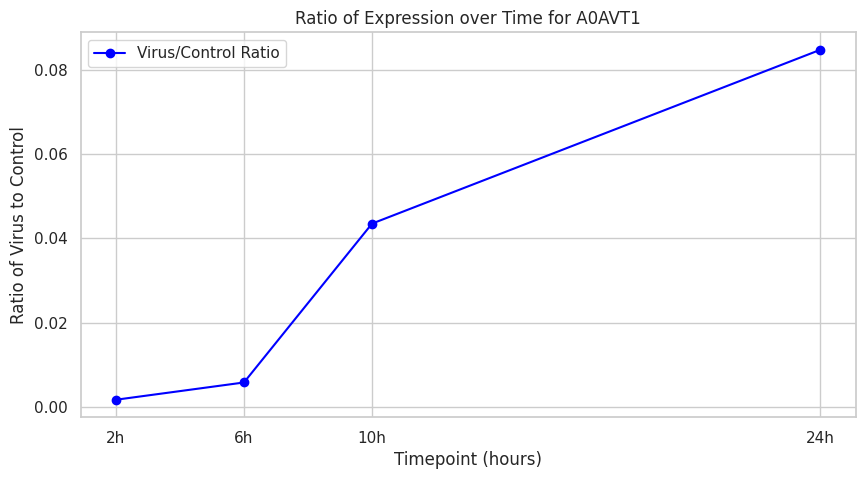

In [37]:
# Sample data extraction for one protein
protein_id = 'A0AVT1'
data = human_timecourse[human_timecourse['UniProt Accession'] == protein_id]

# Define timepoints and numeric representation for proportional x-axis
timepoints = ['2h', '6h', '10h', '24h']
timepoint_hours = [2, 6, 10, 24]  # Hours for x-axis

# Prepare the plot data for ratios
ratios = []

for timepoint in timepoints:
    col_name = f'Ratio {timepoint}'
    value = data[col_name].values  # Get the value for the ratio at each timepoint
    ratios.append(value[0] if len(value) > 0 else np.nan)  # Append the ratio or NaN if missing

# Convert list to numpy array for plotting
ratios = np.array(ratios)

# Create a plot
plt.figure(figsize=(10, 5))
plt.plot(timepoint_hours, ratios, marker='o', linestyle='-', color='blue', label='Virus/Control Ratio')

# Adding title and labels
plt.title(f'Ratio of Expression over Time for {protein_id}')
plt.xlabel('Timepoint (hours)')
plt.ylabel('Ratio of Virus to Control')
plt.xticks(timepoint_hours, labels=timepoints)
plt.legend()
plt.grid(True)
plt.show()

In [38]:
# perform -log10 transform for the p values at each time point

# Define the timepoints
timepoints = ['2h', '6h', '10h', '24h']

# Create a new DataFrame to hold the modified data
transformed_data_human = human_timecourse[['UniProt Accession', 'Gene Symbol']].copy()

# Perform -log10 transformation on P values and copy over ratio values
for tp in timepoints:
    p_value_col = f'P value {tp}'
    ratio_col = f'Ratio {tp}'
    log_p_value_col = f'-log10 P value {tp}'

    # -log10 transformation of the P values
    transformed_data_human[log_p_value_col] = -np.log10(human_timecourse[p_value_col])

    # Copy over the ratio values
    transformed_data_human[ratio_col] = human_timecourse[ratio_col]

# Now, 'transformed_data' contains the transformed p-values and the ratio values
# Display the transformed data
print(transformed_data_human.head())

# Optional: Save this to a new CSV for further use
transformed_data_human.to_csv('transformed_timecourse_data.csv', index=False)

  UniProt Accession Gene Symbol  -log10 P value 2h  Ratio 2h  \
0        A0A0B4J1V1    IGHV3-21           1.680384  0.050572   
1        A0A0B4J2D5         NaN           0.375095 -0.042739   
2        A0A0B4J2F0     PIGBOS1           0.245872  0.016459   
3            A0AV96       RBM47           0.126400  0.017315   
4            A0AVT1        UBA6           0.029842  0.001688   

   -log10 P value 6h  Ratio 6h  -log10 P value 10h  Ratio 10h  \
0           0.351983  0.035375            0.209601   0.029738   
1           0.216568 -0.031764            0.231597   0.025155   
2           0.100863  0.022551            0.174240  -0.038960   
3           0.290102 -0.028862            0.451649   0.039890   
4           0.328427  0.005785            0.810137   0.043469   

   -log10 P value 24h  Ratio 24h  
0            0.010487  -0.004442  
1            2.191717   0.122305  
2            0.541744   0.073575  
3            1.521553  -0.098496  
4            1.852273   0.084703  


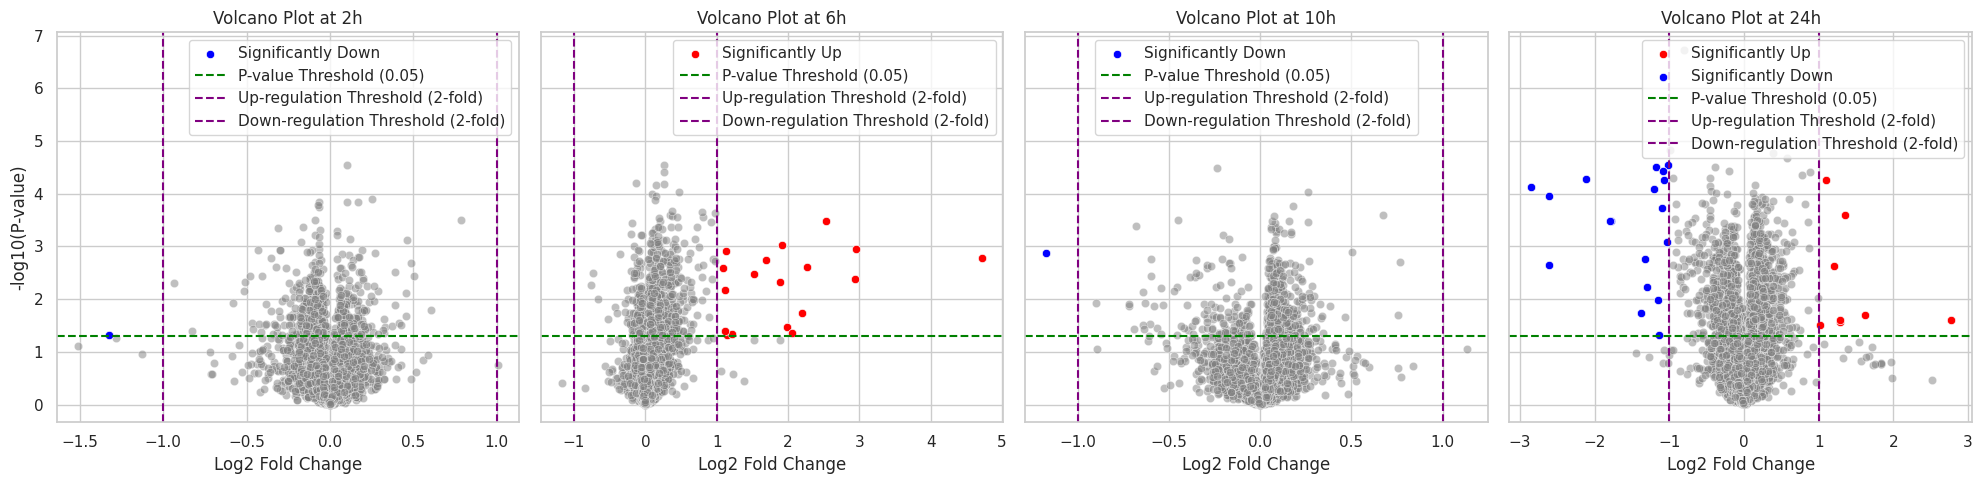

In [39]:
# use the transformed_data_human to produce volcano plot

# Define timepoints
timepoints = ['2h', '6h', '10h', '24h']

# Create a figure with subplots
fig, axes = plt.subplots(1, len(timepoints), figsize=(20, 5), sharey=True)

# Set global aesthetics for seaborn
sns.set(style="whitegrid")

for i, tp in enumerate(timepoints):
    ax = axes[i]
    ratio_col = f'Ratio {tp}'
    log_p_value_col = f'-log10 P value {tp}'

    # Plotting all data points
    sns.scatterplot(x=ratio_col, y=log_p_value_col, data=transformed_data_human, ax=ax, color='gray', alpha=0.5)

    # Highlighting significantly up-regulated proteins
    significantly_up = transformed_data_human[(transformed_data_human[ratio_col] >= 1) & (transformed_data_human[log_p_value_col] >= 1.3)]
    sns.scatterplot(x=ratio_col, y=log_p_value_col, data=significantly_up, ax=ax, color='red', label='Significantly Up')

    # Highlighting significantly down-regulated proteins
    significantly_down = transformed_data_human[(transformed_data_human[ratio_col] <= -1) & (transformed_data_human[log_p_value_col] >= 1.3)]
    sns.scatterplot(x=ratio_col, y=log_p_value_col, data=significantly_down, ax=ax, color='blue', label='Significantly Down')

    # Adding reference lines for significance thresholds
    ax.axhline(y=1.3, color='green', linestyle='--', label='P-value Threshold (0.05)')
    ax.axvline(x=1, color='purple', linestyle='--', label='Up-regulation Threshold (2-fold)')
    ax.axvline(x=-1, color='purple', linestyle='--', label='Down-regulation Threshold (2-fold)')

    # Adding titles and labels
    ax.set_title(f'Volcano Plot at {tp}')
    ax.set_xlabel('Log2 Fold Change')
    ax.set_ylabel('-log10(P-value)')

    # Adding legend
    ax.legend()

plt.tight_layout()
plt.show()

In [40]:
# get overview of transformed human protein data
transformed_data_human

,UniProt Accession,Gene Symbol,-log10 P value 2h,Ratio 2h,-log10 P value 6h,Ratio 6h,-log10 P value 10h,Ratio 10h,-log10 P value 24h,Ratio 24h
0,A0A0B4J1V1,IGHV3-21,1.680384,0.050572,0.351983,0.035375,0.209601,0.029738,0.010487,-0.004442
1,A0A0B4J2D5,NaN,0.375095,-0.042739,0.216568,-0.031764,0.231597,0.025155,2.191717,0.122305
2,A0A0B4J2F0,PIGBOS1,0.245872,0.016459,0.100863,0.022551,0.174240,-0.038960,0.541744,0.073575
3,A0AV96,RBM47,0.126400,0.017315,0.290102,-0.028862,0.451649,0.039890,1.521553,-0.098496
4,A0AVT1,UBA6,0.029842,0.001688,0.328427,0.005785,0.810137,0.043469,1.852273,0.084703
...,...,...,...,...,...,...,...,...,...,...
6366,Q9Y6X2,PIAS3,0.050361,-0.006353,0.479210,-0.025496,0.151562,0.033902,0.231243,0.045961
6367,Q9Y6X4,FAM169A,0.205191,-0.033946,0.047587,-0.002164,0.640655,0.060908,0.926528,0.099740
6368,Q9Y6X9,MORC2,0.034448,0.005799,1.054774,0.178553,2.052617,0.230553,0.022561,-0.007192
6369,Q9Y6Y0,IVNS1ABP,1.452336,0.145721,0.875450,0.084946,0.296172,0.052998,1.268889,0.201341


In [41]:
# separate transformed_data_human based on time point

# Define the columns for each timepoint
timepoint_columns_2h = ['UniProt Accession', 'Gene Symbol', '-log10 P value 2h', 'Ratio 2h']
timepoint_columns_6h = ['UniProt Accession', 'Gene Symbol', '-log10 P value 6h', 'Ratio 6h']
timepoint_columns_10h = ['UniProt Accession', 'Gene Symbol', '-log10 P value 10h', 'Ratio 10h']
timepoint_columns_24h = ['UniProt Accession', 'Gene Symbol', '-log10 P value 24h', 'Ratio 24h']

# Create separate dataframes for each time point
transformed_data_human_2h = transformed_data_human[timepoint_columns_2h]
transformed_data_human_6h = transformed_data_human[timepoint_columns_6h]
transformed_data_human_10h = transformed_data_human[timepoint_columns_10h]
transformed_data_human_24h = transformed_data_human[timepoint_columns_24h]

In [42]:
transformed_data_human_2h

,UniProt Accession,Gene Symbol,-log10 P value 2h,Ratio 2h
0,A0A0B4J1V1,IGHV3-21,1.680384,0.050572
1,A0A0B4J2D5,NaN,0.375095,-0.042739
2,A0A0B4J2F0,PIGBOS1,0.245872,0.016459
3,A0AV96,RBM47,0.126400,0.017315
4,A0AVT1,UBA6,0.029842,0.001688
...,...,...,...,...
6366,Q9Y6X2,PIAS3,0.050361,-0.006353
6367,Q9Y6X4,FAM169A,0.205191,-0.033946
6368,Q9Y6X9,MORC2,0.034448,0.005799
6369,Q9Y6Y0,IVNS1ABP,1.452336,0.145721


In [43]:
# Filtering function for significant proteins
def extract_significant_proteins(df, p_value_col, ratio_col):
    filtered_df = df[(df[p_value_col] > 1.3) & ((df[ratio_col] >= 1) | (df[ratio_col] <= -1))]
    up_regulated = filtered_df[filtered_df[ratio_col] >= 1][['UniProt Accession', 'Gene Symbol']]
    down_regulated = filtered_df[filtered_df[ratio_col] <= -1][['UniProt Accession', 'Gene Symbol']]
    return up_regulated, down_regulated

# Applying the function for each time point
up_2h, down_2h = extract_significant_proteins(transformed_data_human_2h, '-log10 P value 2h', 'Ratio 2h')
up_6h, down_6h = extract_significant_proteins(transformed_data_human_6h, '-log10 P value 6h', 'Ratio 6h')
up_10h, down_10h = extract_significant_proteins(transformed_data_human_10h, '-log10 P value 10h', 'Ratio 10h')
up_24h, down_24h = extract_significant_proteins(transformed_data_human_24h, '-log10 P value 24h', 'Ratio 24h')

In [44]:
print(f"up_2h: {up_2h}")
print(f"down_2h: {down_2h}")

up_2h: Empty DataFrame
Columns: [UniProt Accession, Gene Symbol]
Index: []
down_2h:      UniProt Accession Gene Symbol
6075            Q9UPW0       FOXJ3


In [45]:
print(f"up_6h: {up_6h}")
print(f"down_6h: {down_6h}")

up_6h:          UniProt Accession        Gene Symbol
445                 O60669            SLC16A7
731                 O95466              FMNL1
867   P02533;Q04695;P08779  KRT14;KRT16;KRT17
1088                P09488              GSTM1
1125                P10321              HLA-C
1137                P10909                CLU
1227         P13929;P09104          ENO2;ENO3
1237                P14384                CPM
1512                P26006              ITGA3
2646                Q03135               CAV1
2750                Q0ZGT2               NEXN
3333         Q2HJF0;Q0IIK2                NaN
4804         Q96T88;Q96PU4        UHRF1;UHRF2
5390                Q9HAV0               GNB4
5694                Q9NYJ1               COA4
5739                Q9NZR1              TMOD2
5814                Q9TT36                NaN
5830                Q9UBK8               MTRR
down_6h: Empty DataFrame
Columns: [UniProt Accession, Gene Symbol]
Index: []


In [46]:
print(f"up_10h: {up_10h}")
print(f"down_10h: {down_10h}")

up_10h: Empty DataFrame
Columns: [UniProt Accession, Gene Symbol]
Index: []
down_10h:      UniProt Accession Gene Symbol
5135            Q9C099      LRRCC1


In [47]:
print(f"up_24h: {up_24h}")
print(f"down_24h: {down_24h}")

up_24h:                        UniProt Accession                Gene Symbol
701                               O95274                      LYPD3
869   P02533;Q9D312;Q04695;P08779;P35900    KRT14;KRT16;KRT17;KRT20
3294                Q16777;Q93077;P16104  H2AFX;HIST1H2AC;HIST2H2AC
3321                              Q17RY6                       LY6K
3346                              Q2TB90                      HKDC1
4316                              Q8WVM7                      STAG1
4701                       Q96K21;Q07065              CKAP4;ZFYVE19
6066                              Q9UPN7                     PPP6R1
down_24h:                        UniProt Accession                 Gene Symbol
136                               O00767                         SCD
874                               P02652                       APOA2
880                               P02766                         TTR
883                               P02771                         AFP
962                      

In [48]:
# code to generate list of gene symbols

# # Extract gene symbols for up-regulated genes at 6h
# upregulated_genes_6h = up_6h['Gene Symbol'].dropna().tolist()
#
# # Extract gene symbols for down-regulated genes at 6h (which is empty in this case)
# downregulated_genes_6h = down_6h['Gene Symbol'].dropna().tolist()
#
# print("Up-regulated genes at 6h:", upregulated_genes_6h)
# print("Down-regulated genes at 6h:", downregulated_genes_6h)

To summarise:

**Up-regulated Genes**

- 2h: None
- 6h: SLC16A7, FMNL1, KRT14;KRT16;KRT17, GSTM1, HLA-C, CLU, ENO2;ENO3, CPM, ITGA3, CAV1, NEXN, UHRF1;UHRF2, GNB4, COA4, TMOD2, MTRR
- 10h: None
- 24h: LYPD3, KRT14;KRT16;KRT17;KRT20, H2AFX;HIST1H2AC;HIST2H2AC, LY6K, HKDC1, STAG1, CKAP4;ZFYVE19, PPP6R1

**Down-regulated Genes**

- 2h: FOXJ3
- 6h: None
- 10h: LRRCC1
- 24h: SCD, APOA2, TTR, AFP, CCK, DBI, PPIA;PPID;PPIF;PPIH;RANBP2, TMBIM6, SEPW1, APLP2;APP, INSL4, SHH, AFP, GPR64, IDI2, TSPYL1, ATP6V0A4, COA4


## Analysis results

Use the relevant bioinformatics tools to analysis and produce results:
- gprofiler
- uniport
- panther

In [49]:
# Define the list of up and down-regulated genes
up_2h = []
down_2h = ['FOXJ3']
up_6h = ['SLC16A7', 'FMNL1', 'KRT14', 'KRT16', 'KRT17', 'GSTM1', 'HLA-C', 'CLU', 'ENO2', 'ENO3', 'CPM', 'ITGA3', 'CAV1', 'NEXN', 'UHRF1', 'UHRF2', 'GNB4', 'COA4', 'TMOD2', 'MTRR']
down_6h = []
up_10h = []
down_10h = ['LRRCC1']
up_24h = ['LYPD3', 'KRT14', 'KRT16', 'KRT17', 'KRT20', 'H2AFX', 'HIST1H2AC', 'HIST2H2AC', 'LY6K', 'HKDC1', 'STAG1', 'CKAP4', 'ZFYVE19', 'PPP6R1']
down_24h = ['SCD', 'APOA2', 'TTR', 'AFP', 'CCK', 'DBI', 'PPIA', 'PPID', 'PPIF', 'PPIH', 'RANBP2', 'TMBIM6', 'SEPW1', 'APLP2', 'APP', 'INSL4', 'SHH', 'AFP', 'GPR64', 'IDI2', 'TSPYL1', 'ATP6V0A4', 'COA4']

# Combined lists of up and down-regulated genes
all_regulated_genes = up_2h + down_2h + up_6h + down_6h + up_10h + down_10h + up_24h + down_24h

# Define the list of interest
genes_of_interest = ['PPP2R3B', 'GIGYF2', 'EIF4E2', 'VDAC3', 'RAP1GDS1', 'PGRMC1', 'VDAC1', 'MT-CO2', 'FKBP15',
                     'COX4I1', 'COX5B', 'TMPO', 'KIF26A', 'ATP5PD', 'SLC27A2', 'ELOC', 'COX7A2', 'BSG', 'CANX',
                     'UQCRC2', 'RPN1', 'COX5A', 'ATP5PB', 'WASHC4', 'COX7C', 'WASHC2A', 'UQCRC1', 'POR', 'RPN2',
                     'GNB1', 'RNF2', 'WASHC5', 'AMOT', 'MT-ATP6', 'RRM1', 'CASP2', 'DDOST', 'ATP5MF', 'NDUFA9',
                     'ATP5F1D', 'CORO1C', 'ATP5MG', 'MIEF1', 'KIF2A', 'ISCA2', 'ARPC3', 'PSMC2', 'THAP11', 'IPO5']

# Find common genes between regulated genes and genes of interest
common_genes = list(set(all_regulated_genes).intersection(genes_of_interest))

# Display the common genes
print(common_genes)

[]


There was no common proteins from the human protein that were in NSP2 virus proteins.

For further investigation, consider take nsp2 protein to plot